In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib as mpl

sys.path.insert(0, '..')
from ccal import *

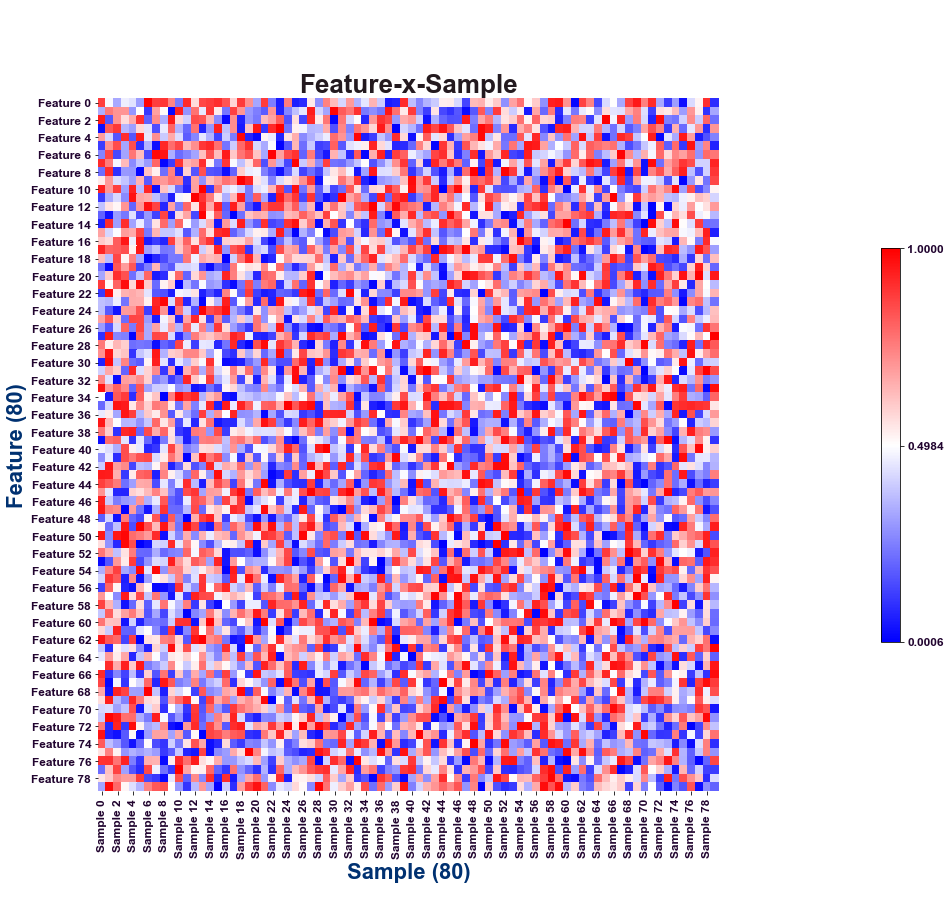

In [3]:
n_row = 80
n_column = 80

feature_x_sample = pd.DataFrame(
    np.random.random_sample((n_row, n_column)),
    index=('Feature {}'.format(i) for i in range(n_row)),
    columns=('Sample {}'.format(i) for i in range(n_column)))

plot_heatmap(
    feature_x_sample,
    title='Feature-x-Sample',
    decorate_ax_kwargs={
        'xlabel': 'Sample',
        'ylabel': 'Feature',
    })

In [4]:
output_directory_path = clean_path('.')
print(output_directory_path)
assert os.path.isdir(output_directory_path)

/Users/k/Jumis/github_kwatme/ccal/notebook


In [5]:
a_matrix_normalization_method = '0-1'
a_matrix_normalization_axis = 0

In [6]:
n_job = 2

nmf_ks = tuple(range(2, 4))
nmf_n_clustering = 10
nmf_parameters = '__'.join((str(parameter)
                            for parameter in (
                                'nmf',
                                a_matrix_normalization_axis,
                                a_matrix_normalization_method,
                                nmf_n_clustering, )))
print('NMF parameters: {}'.format(nmf_parameters))

NMF parameters: nmf__0__0-1__10


In [7]:
h_hcc_ks = nmf_ks
h_hcc_distance_function = 'euclidean'
h_hcc_n_clustering = nmf_n_clustering * 10
h_hcc_linkage_method = 'ward'
h_hcc_parameters = '__'.join((str(parameter)
                              for parameter in (
                                  'hcc',
                                  h_hcc_distance_function,
                                  h_hcc_n_clustering,
                                  h_hcc_linkage_method, )))
print('H HCC parameters: {}'.format(h_hcc_parameters))

H HCC parameters: hcc__euclidean__100__ward


In [8]:
w_hcc_ks = nmf_ks
w_hcc_distance_function = h_hcc_distance_function
w_hcc_n_clustering = nmf_n_clustering * 10
w_hcc_linkage_method = h_hcc_linkage_method
w_hcc_parameters = '__'.join((str(parameter)
                              for parameter in (
                                  'hcc',
                                  w_hcc_distance_function,
                                  w_hcc_n_clustering,
                                  w_hcc_linkage_method, )))
print('W HCC parameters: {}'.format(w_hcc_parameters))

W HCC parameters: hcc__euclidean__100__ward


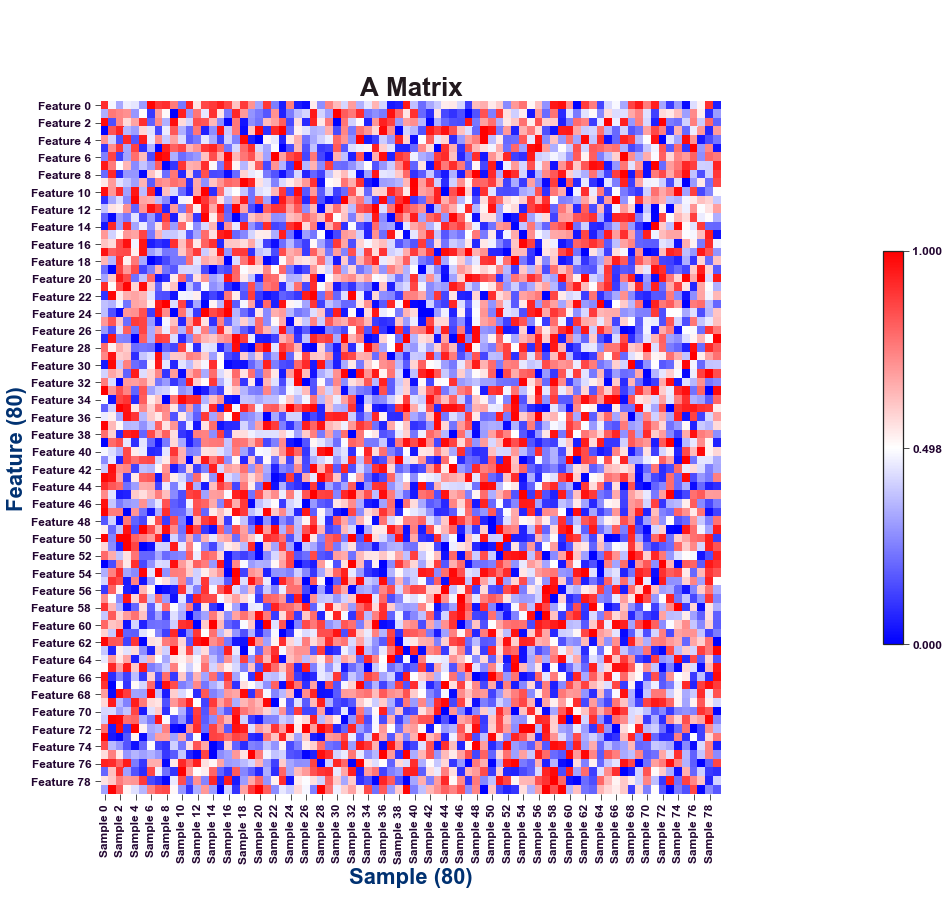

In [9]:
a = pd.DataFrame(
    normalize_2d_array(feature_x_sample.values, a_matrix_normalization_method,
                       a_matrix_normalization_axis),
    index=feature_x_sample.index,
    columns=feature_x_sample.columns)

a = a.loc[(a != 0).any(axis=1)]

plot_heatmap(
    a,
    title='A Matrix',
    decorate_ax_kwargs={
        'xlabel': 'Sample',
        'ylabel': 'Feature',
    })

NMFCC with K=3 ...
NMFCC with K=2 ...
	(K=2) 10/10 - done.
	(K=3) 10/10 - done.


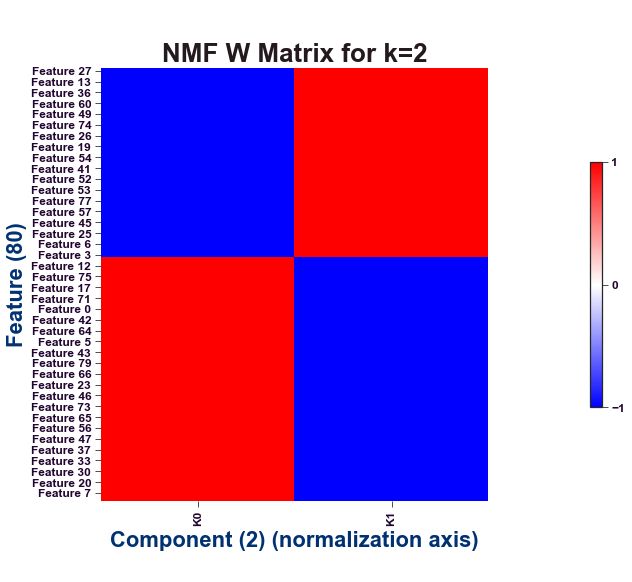

2: W axis-0 sum:
K0    42.026788
K1    40.288064
dtype: float64


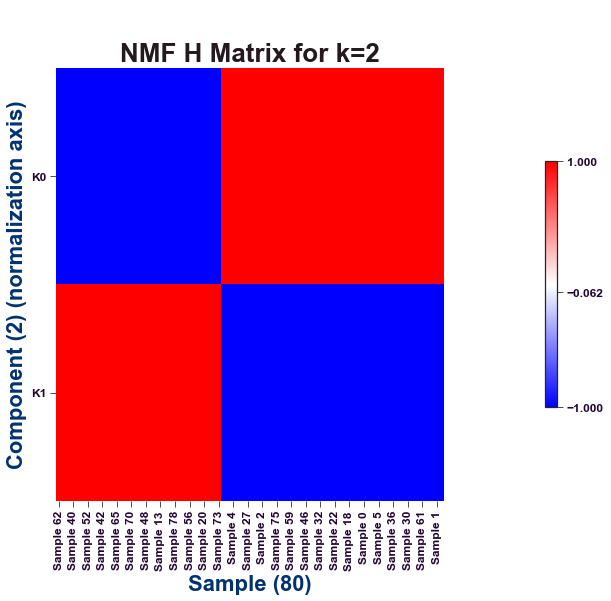

2: H axis-1 sum:
K0    42.343760
K1    35.000023
dtype: float64


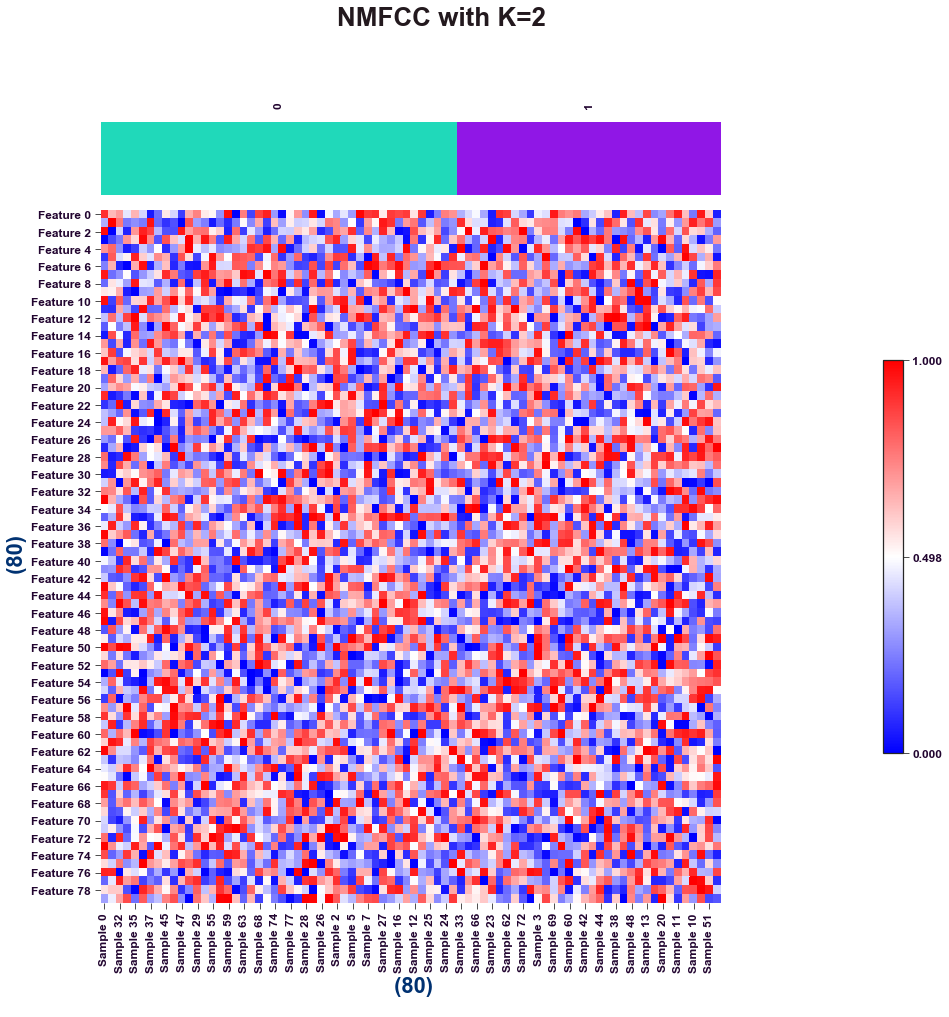

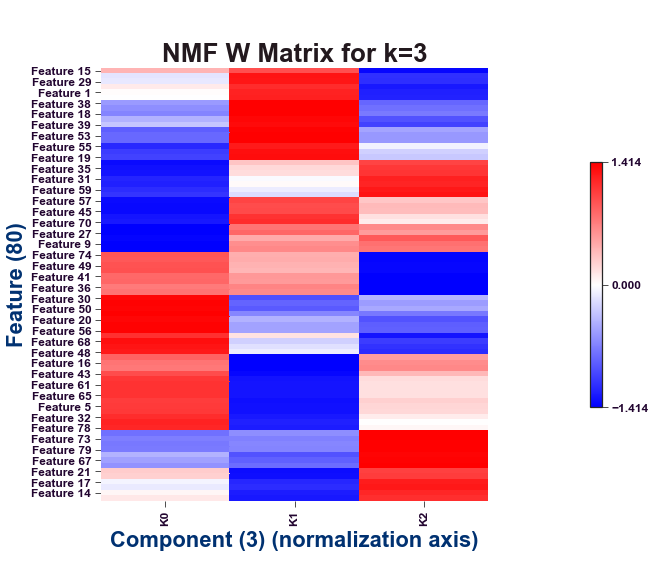

3: W axis-0 sum:
K0    33.597350
K1    35.066078
K2    32.617155
dtype: float64


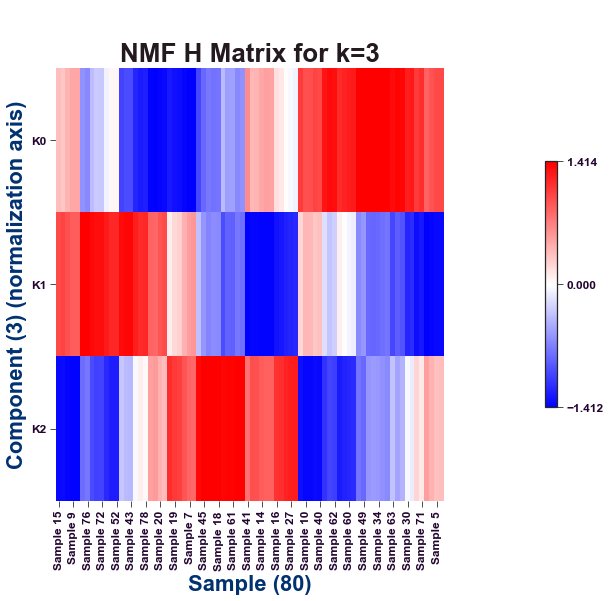

3: H axis-1 sum:
K0    34.279662
K1    28.947734
K2    31.385762
dtype: float64


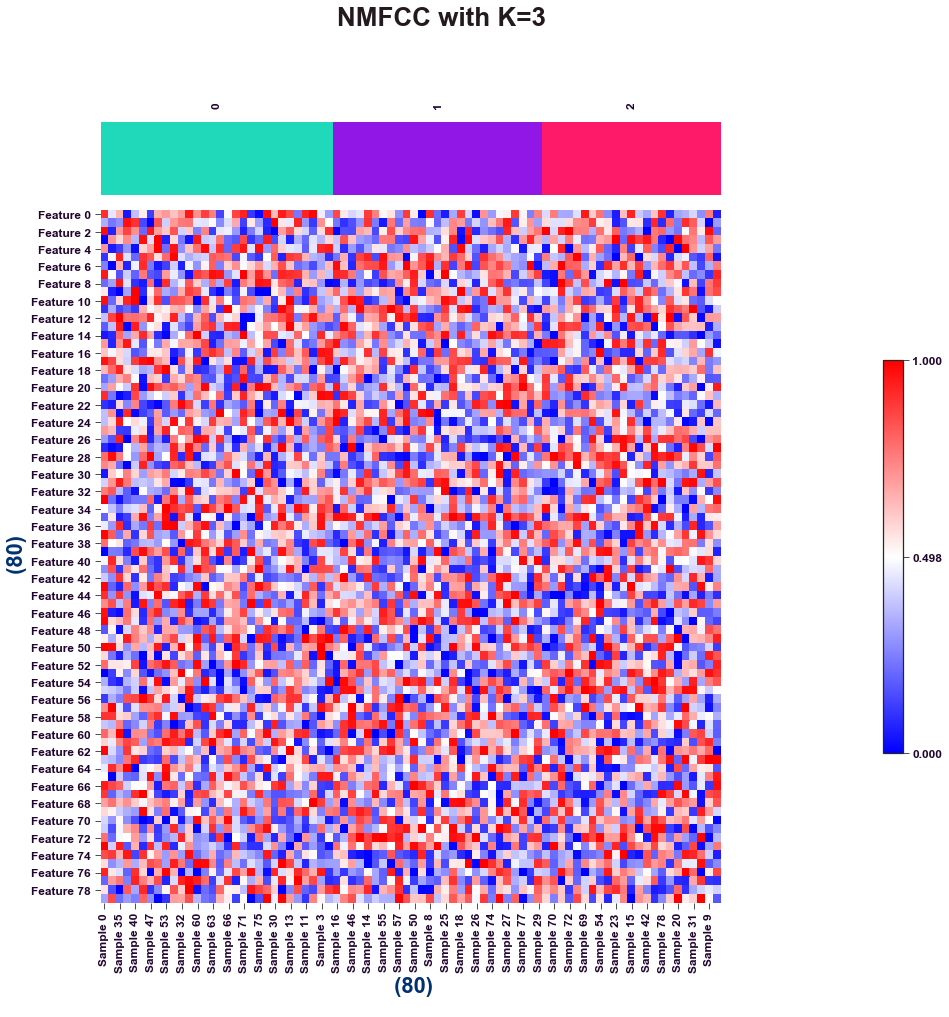

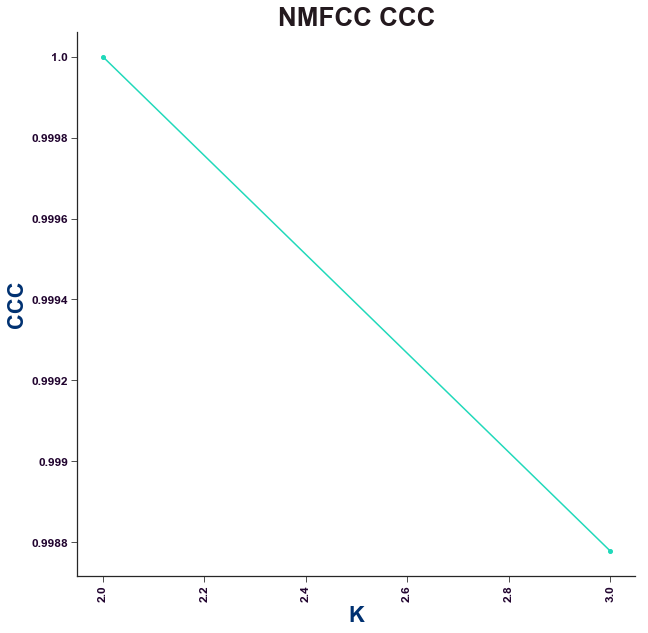

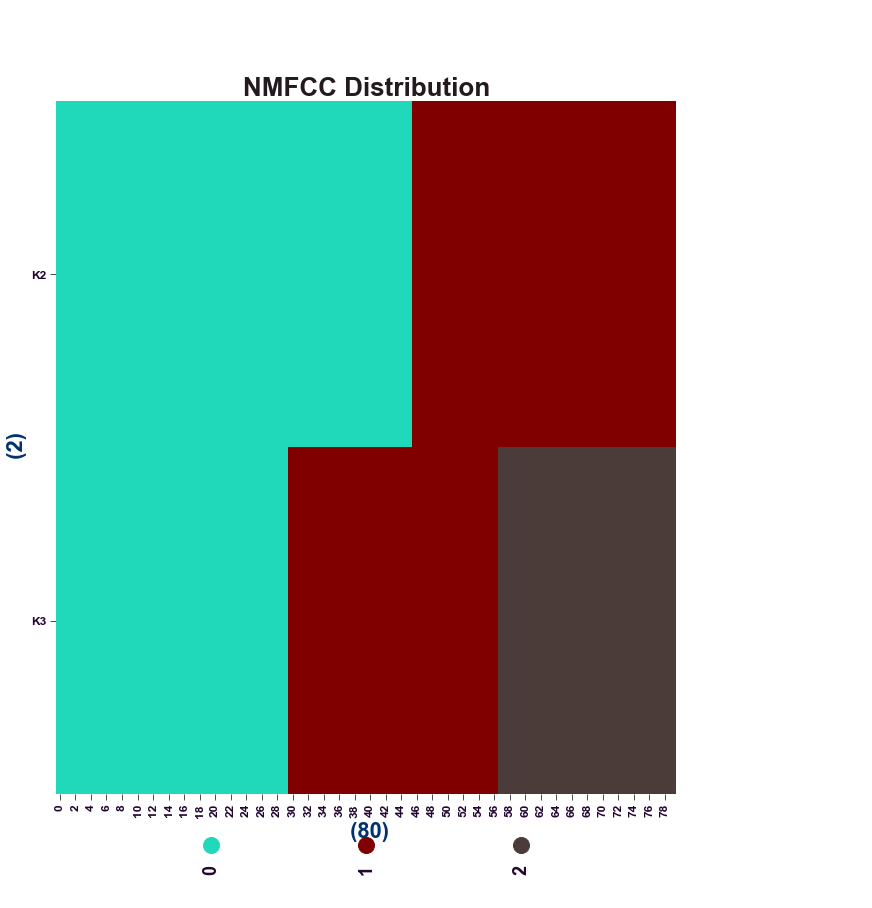

In [10]:
k_nmf, k_nmfcc_distance_linkage_ccc, nmfcc__k_x_column = explore_components(
    a,
    nmf_ks,
    n_job=n_job,
    n_clustering=nmf_n_clustering,
    directory_path='{}/{}'.format(output_directory_path, nmf_parameters))

In [11]:
nmf_k = 3

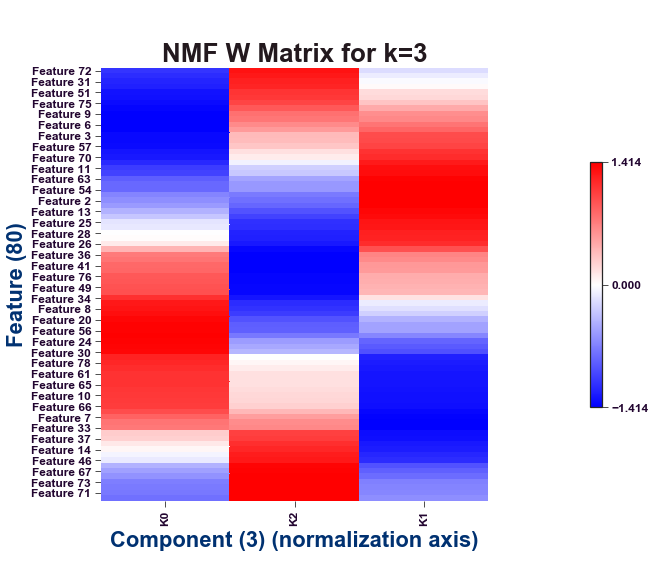

3: W axis-0 sum:
K0    33.597350
K1    35.066078
K2    32.617155
dtype: float64


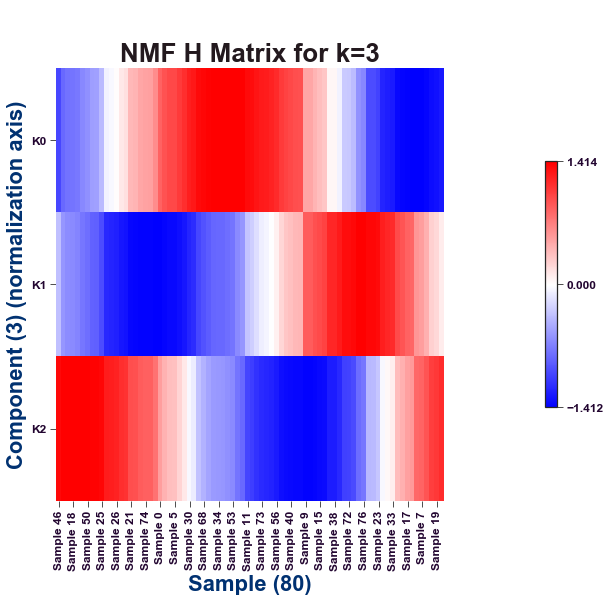

3: H axis-1 sum:
K0    34.279662
K1    28.947734
K2    31.385762
dtype: float64


In [12]:
# w__feature_x_component = pd.read_table(
#     '{}/{}/nmf_k{}_w.tsv'.format(output_directory_path, nmf_parameters, nmf_k),
#     index_col=0)

# h__component_x_sample = pd.read_table(
#     '{}/{}/nmf_k{}_h.tsv'.format(output_directory_path, nmf_parameters, nmf_k),
#     index_col=0)

w__feature_x_component = k_nmf['K{}'.format(nmf_k)]['w']

h__component_x_sample = k_nmf['K{}'.format(nmf_k)]['h']

plot_nmf(w__feature_x_component, h__component_x_sample)

In [ ]:
normalize_and_plot_heatmap(w__feature_x_component)
normalize_and_plot_heatmap(h__component_x_sample)

In [ ]:
# normalized__h_component_x_sample = pd.DataFrame(
#     normalize_2d_array(h__component_x_sample.values, '-0-', axis=1).clip(
#         -3, 3),
#     index=h__component_x_sample.index,
#     columns=h__component_x_sample.columns)

normalized__h_component_x_sample = h__component_x_sample

if h_hcc_distance_function == 'information_distance':
    h_hcc_distance_function = compute_information_distance

distance__column_x_column, k_hcc_distance_linkage, k_hcc_distance_linkage_ccc, hcc__k_x_column = hierarchical_consensus_cluster_with_multiple_k(
    normalized__h_component_x_sample,
    h_hcc_ks,
    n_job=n_job,
    distance_function=h_hcc_distance_function,
    n_clustering=h_hcc_n_clustering,
    linkage_method=h_hcc_linkage_method,
    directory_path='{}/{}/{}/h/{}'.format(
        output_directory_path, nmf_parameters, nmf_k, h_hcc_parameters))

In [ ]:
gps_map = GPSMap(
    normalized__h_component_x_sample,
    pull_power=2.6,
    mds_distance_function=h_hcc_distance_function)

gps_map.sample_marker_style.update({
    'markersize': 12.6,
})

gps_map.plot_samples()

In [ ]:
for hcc_k, sample_state in hcc__k_x_column.iterrows():

    if sample_state.value_counts().min() < 3:
        print(
            'Skipping {}, who has at least 1 state with less than 3 samples ...'.
            format(hcc_k))

    else:
        hcc_k = int(hcc_k.strip('K'))

        gps_map.set_sample_phenotypes(
            sample_state,
            bandwidth_factor=2.6,
            phenotype_to_str={i: 'State {}'.format(i)
                              for i in range(hcc_k)})

        gps_map.plot_samples_with_phenotype(
            plot_heatmap_=True,
            plot_centroid=True,
            file_path='{}/{}/{}/h/{}/gps_map__hcc_k{}.png'.format(
                output_directory_path, nmf_parameters, nmf_k, h_hcc_parameters,
                hcc_k))

        mpl.pyplot.show()

In [ ]:
component_x_feature = w__feature_x_component.T

In [ ]:
# normalized__component_x_feature = pd.DataFrame(
#     normalize_2d_array(component_x_feature.values, '-0-', axis=1).clip(-3, 3),
#     index=component_x_feature.index,
#     columns=component_x_feature.columns)

normalized__component_x_feature = component_x_feature

if w_hcc_distance_function == 'information_distance':
    w_hcc_distance_function = compute_information_distance

distance__column_x_column, k_hcc_distance_linkage, k_hcc_distance_linkage_ccc, hcc__k_x_column = hierarchical_consensus_cluster_with_multiple_k(
    normalized__component_x_feature,
    w_hcc_ks,
    n_job=n_job,
    distance_function=w_hcc_distance_function,
    n_clustering=w_hcc_n_clustering,
    linkage_method=w_hcc_linkage_method,
    directory_path='{}/{}/{}/w/{}'.format(
        output_directory_path, nmf_parameters, nmf_k, w_hcc_parameters))

In [ ]:
gps_map = GPSMap(
    normalized__component_x_feature,
    pull_power=3.9,
    mds_distance_function='euclidean')

gps_map.sample_marker_style.update({
    'markersize': 18,
})

gps_map.plot_samples()

mpl.pyplot.show()

In [ ]:
for hcc_k, sample_state in hcc__k_x_column.iterrows():

    if sample_state.value_counts().min() < 3:
        print(
            'Skipping {}, who has at least 1 state with less than 3 samples ...'.
            format(hcc_k))

    else:
        hcc_k = int(hcc_k.strip('K'))

        gps_map.set_sample_phenotypes(
            sample_state,
            bandwidth_factor=2.6,
            phenotype_to_str={
                i: 'State Element {}'.format(i)
                for i in range(hcc_k)
            })

        gps_map.plot_samples_with_phenotype(
            plot_heatmap_=True,
            plot_centroid=True,
            file_path='{}/{}/{}/w/{}/gps_map__hcc_k{}.png'.format(
                output_directory_path, nmf_parameters, nmf_k, h_hcc_parameters,
                hcc_k))

        mpl.pyplot.show()